#**DBSCAN Clustering Algorithm from Scratch.**
>*Comparison with DBSCAN Using Sklearn*


###**import statements**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

###**Defining Helper functions**

###**Distance class definition**
>for calculating different type of distances between two n-dimensional points

In [2]:
class Distance:
    def __init__(self,algo='euclidean',Power=2):
        self.algo=algo
        # Power -> power value used for MinKowski distance
        self.P=Power

    def calc(self,p1,p2):
        '''
        Input
            p1,p2 -> numpy array of size d denoting  d-dimenstional points
        Output
            it returns the distance(in np.float64 dtype) based on the algo
        '''
        if self.algo=='minkowski':
            return self.minkowskiDist(p1,p2,self.P)
        elif self.algo=='euclidean':
            return self.euclideanDist(p1,p2)
        elif self.algo=='manhatten':
            return self.manhattenDist(p1,p2)
    
    def algo(self):
        '''
         this function returns the names of algo's that we can use in this class
        '''
        return ['euclidean','minkowski','manhatten']

    def minkowskiDist(self,p1,p2,P):
        return np.power(np.sum(np.power(p2-p1,P)),1/P)
    
    def euclideanDist(self,p1,p2):
        return np.sqrt(np.sum(np.square(p2-p1)))
    
    def manhattenDist(self,p1,p2):
        return np.sum(np.absolute(p2-p1))

In [3]:
# defining helper function for our code.
def scaleDf(df,colList=[]):
    '''
    scaleDf -> this function scale the value of features in df using MinMaxScaler
    colList-> user can pass a list of features to scale otherwise all features are scaled
    '''
    scaler=MinMaxScaler()
    #if colList is not given then take all columns
    if(len(colList)==0):
        colList=df.columns
    df=pd.DataFrame(scaler.fit_transform(df[colList]),columns=colList)
    return df


def plotClusters(df,labels,cluster_centers=[]):
    '''
    Input : 
        df -> dataFrame
        labels -> labels
    Output:
        plot the clusters
    '''
    labels=np.array(labels) #convert in numpy array (if not already)
    # changing noise points label value to give noise points a diffrent color
    noise_label=labels.max()+1
    Labels=labels.copy()
    Labels[Labels==-1]=noise_label
    #plotting
    # plotting cluster points
    for label in np.unique(Labels):
        # declaring name for clusters ('N'-> noise points)
        cluster_name='C'+str(int(label)) if label!=noise_label else 'N'
        # at color position we passed label+1 because to avoid white color(that is for 0)
        plt.scatter(df[Labels==label].iloc[:,0],df[Labels==label].iloc[:,1],label+1,label=cluster_name)
    # plotting cluster centers
    # only plot cluster centers when cluster centers are 2D points
    cluster_centers=np.array(cluster_centers) # convert in numpy (if not already)
    if len(cluster_centers.shape)>=2 and cluster_centers.shape[1]==2:
        for point in cluster_centers:
            # label='CC' in plot represents cluster centers
            plt.scatter(point[0],point[1],s=80,c=Labels.max()+2,marker='^',label='CC')
    plt.legend(loc='upper left')
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.plot()
    plt.show()

# extra helper function for calculation of inertia of sklearn DBSCAN clustering model

def squared_distance_sum(points,centroid,dist_func='euclidean',power=2):
        '''
        Input:
            points -> collection of points of a single cluster
            centroid -> centroid of that cluster
            dist_func-> algo used for calculating distance
            power -> power used in minkowski algo
        Output:
            this function returns the sum of square of distance of 
            every point in points from given centroid
        '''
        distance=Distance(algo=dist_func,Power=power)
        sum_squared_dist=0
        for point in points:
            sum_squared_dist+=np.square(distance.calc(point,centroid))
        return sum_squared_dist

def get_cluster_cnt(labels):
    '''
    Input:
        labels -> list of clusters label for each point
    Output:
        it returns count of clusters created by DBSCAN
    '''
    labels=np.array(labels) #convert lables into numpy array in the case it is mot already
    cluster_cnt=np.unique(labels).shape[0]
    #if labels contains -1 means it have noise (and we dont count noise as a cluster)
    if -1 in labels:
        cluster_cnt-=1
    return cluster_cnt

def get_cluster_centers(df,labels):
    '''
    Input:
        df-> data frame
        labels -> list of clusters label for each point
    Output:
        it returns array containing cluster center for each cluster
    '''
    df_numpy=df.to_numpy()
    labels=np.array(labels) #convert lables into numpy array in the case it is mot already
    cluster_cnt=get_cluster_cnt(labels)  
    #creating variable for storing cluster_centers
    cluster_centers=np.ones(((df_numpy.shape[1])*cluster_cnt)).reshape(cluster_cnt,df_numpy.shape[1])
    # now we iterate over clusters and find centers
    for c_num in range(cluster_cnt):
        c_num_points=df_numpy[labels==c_num]
        cluster_centers[c_num]=((c_num_points.sum(axis=0))/(c_num_points.shape[0]))
    return cluster_centers

def getInertia(df,labels,dist_func='euclidean',power=2):
    '''
    Input 
        df -> data frame
        labels -> list of clusters label for each point
        dist_func-> algo used for calculating distance
        power -> power used in minkowski algo
    Output
        returns sum of squared distace from every point to there assigned cluster center
    '''
    df_numpy=df.to_numpy()
    labels=np.array(labels) #convert lables into numpy array in the case it is mot already
    total_squared_dist=0
    cluster_cnt=get_cluster_cnt(labels)
    # if cluster center is already calculated then use it otherwise calculate it
    cluster_centers=get_cluster_centers(df,labels)
    for cluster_num in range(cluster_cnt):
        cluster_points=df_numpy[labels==cluster_num]
        center=cluster_centers[cluster_num]
        total_squared_dist+=squared_distance_sum(cluster_points,center)
    return total_squared_dist


###**DB_SCAN Class Implementation**

In [4]:
# (Distance class must be there and executed for working of this K_Means Class)
# My DB_SCAN class starts here
class DB_SCAN:
    def __init__(self,eps=0.5, *, min_samples=5, Distance_algo='euclidean', p=2):
        self.eps=eps # radius of circle for a core point
        self.min_samples=min_samples # min number of neighbours to be called a core point
        self.Distance_algo=Distance_algo
        self.P=p #Power used for Minkowski distance
        #additional data attribute
        self.n_features_in_=0 # number of features seen during fitting
        self.labels_=np.array([]) # stores the labels of every point in data
        self.cluster_cnt_=0 # it stores the number of clusters formed after fitting the data
        self.cluster_centers_=np.array([]) # it stores cluster center of each clusters(size=cluster_cnt)
    
    def get_params(self):
        '''
        Returns DB_SCAN Model parameters with their values
        '''
        params=dict()
        params['eps']=self.eps
        params['min_samples']=self.min_samples
        params['Distance_algo']=self.Distance_algo
        params['p']=self.p
        return params

    def fit(self,df):
        '''
        Input
            df -> a data frame containing n data points with d features each
        Output
            the predicted cluster number corresponding to each point
        '''
        # creating points
        df_numpy=df.to_numpy(copy=True) #convert df to np array

        inertia=np.inf #store the minimum inertia across runs
        
        # defining variables
        eps=self.eps
        minpts=self.min_samples # min number of neighbours to be called a core point
        dist_func=self.Distance_algo
        rows=df_numpy.shape[0]
        cols=df_numpy.shape[1]

        c=-1 # cluster not started yet
        '''
        labels[i] -> label of ith point in df_numpy
        value:
            -5 -> undefined (point not visited yet!)
            -1 -> Noise point
            >=0 -> cluster label(Cluster number in which it belongs)
        '''
        labels=np.ones(rows)*-5 #initially no points is unvisited

        # iterate over points
        for i in range(rows):
            p=df_numpy[i]
            # if point p is already visited then continue
            if labels[i]!=-5:
                continue
            # if point p is not visited yet then visit it and find its neighbours
            #n_idxs -> its stores the index of neighbours of point p
            n_idxs=self.get_neighbours(df_numpy[i],df_numpy)
            # type(n_idxs)=list
            # n_cnt-> neighbours cnt of point p
            n_cnt=len(n_idxs)

            # if n_cnt is less than minpts then it become a noise point (at this moment), and then continue
            if n_cnt<minpts:
                labels[i]=-1 # -1 is label for noise
                continue
            # if n_cnt>=minpts means p is a core point and we can start a new cluster from p
            # initializing a new cluster
            c=c+1
            #assign the new cluster label to point p
            labels[i]=c

            #creating a set of n_idxs for faster searching
            n_idxs_set=set(n_idxs)

            # iterate over neightbours of point p
            for idx in n_idxs:
                q=df_numpy[idx]
                # here q is neighbour of p
                # if q is a noise point then we assign it to our currennt cluster c and continue
                if labels[idx]==-1:
                    labels[idx]=c
                    continue
                # if already visited then continue
                if labels[idx]!=-5:
                    continue
                
                # Assign level already 
                labels[idx]=c
                # find neighbours of q
                # nidx-> it stores indexes of neighbours of q
                nIdx=self.get_neighbours(q,df_numpy)
                nCnt=len(nIdx)
                # if q is a core point then add neighbours of q into neighbours of p (by union method)
                if nCnt>=minpts:
                    # q is a core point
                    # taking union of n_idxs and nIdx (can't do direct union because indexing of above for loop mismatched after sorting)
                    #taking union in a diffrent way
                    for idx in nIdx:
                        if idx in n_idxs_set:
                            continue
                        #append idx in n_idxs and add idx in n_idxs_set
                        n_idxs_set.add(idx)
                        n_idxs.append(idx)

                # if q is not a core point then do nothing
        # store the final values in corresponding attributes
        self.n_features_in_=labels.shape[0]
        self.labels_=labels
        self.cluster_cnt_=self.get_cluster_cnt(labels)
        self.cluster_centers_=self.get_cluster_centers(df_numpy,labels)
        self.inertia_=self.getInertia(df_numpy,labels)
        return self.labels_

    def get_neighbours(self,p,df_numpy):
        '''
        Input
            p-> point (d dimensional point)
            eps -> epsillon distance
            df_numpy -> dataframe in numpy format
            dist_func-> denotes distance function
        Output
            (return type is list)
            index arr of neighbours which lies on/inside the d-dimensional circle with radius=eps , center=p
        '''
        # defining variables
        eps=self.eps
        dist_func=self.Distance_algo

        # initialize the distance class with given algo
        distance=Distance(algo=self.Distance_algo,Power=self.P)
        # iterate over every point in df_numpy
        neighbours_idxs=[] # this stores indexes of neighbours 
        for i,q in enumerate(df_numpy):
            # dist stores distance between point p and q
            dist=distance.calc(p,q)
            if dist<=eps:
                neighbours_idxs.append(i)
        return neighbours_idxs

    def squared_distance_sum(self,points,centroid):
        '''
        this function returns the sum of square of distance of 
        every point in points from given centroid
        '''
        distance=Distance(algo=self.Distance_algo,Power=self.P)
        sum_squared_dist=0
        for point in points:
            sum_squared_dist+=np.square(distance.calc(point,centroid))
        return sum_squared_dist

    
    def getInertia(self,df_numpy,labels):
        '''
        Input 
          df_numpy -> data points
          labels -> list of clusters label for each point
        Output
          returns sum of squared distace from every point to there assigned cluster center
        '''
        total_squared_dist=0
        cluster_cnt=self.get_cluster_cnt(labels)
        # if cluster center is already calculated then use it otherwise calculate it
        cluster_centers=self.cluster_centers_
        if len(self.cluster_centers_)!=cluster_cnt:
            cluster_centers=self.get_cluster_centers(df_numpy,labels)
        
        for cluster_num in range(cluster_cnt):
            cluster_points=df_numpy[labels==cluster_num]
            center=cluster_centers[cluster_num]
            total_squared_dist+=self.squared_distance_sum(cluster_points,center)
        return total_squared_dist

    def predict(self,test_df):
        '''
        (prerequisite -> fit already executed (model already built))
        Input :
            df_test -> test data points
        Ouput:
            returns Cluster number corresponding to each test data point
        '''
        # Print error if models is prerequisite not satisfied
        if(self.n_iter_==0):
            print("\tPlease Contruct and Fit the Model First (Run the Fit method)\n")
            return np.array([])
        test_pts=test_df.to_numpy(copy=True) #convert test_df to np array
        labels=[-1 for i in range(len(test_pts))]
        for i,point in enumerate(test_pts):
            labels[i]=self.get_nearest_centroid(point,self.cluster_centers_)
        return labels
    
    def specs_(self):
        '''
        return Model Specifications (after fitting on dataset)
        '''
        specs=dict()
        specs['inertia_']=self.inertia_
        specs['cluster_cnt_']=self.cluster_cnt_
        specs['cluster_centers_']=self.cluster_centers_
        specs['n_features_in_']=self.n_features_in_
        return specs


    # Helper Functions
    def get_cluster_cnt(self,labels):
        '''
        Input:
            labels -> list of clusters label for each point
        Output:
            it returns count of clusters created by dbscan
        '''
        cluster_cnt=np.unique(labels).shape[0]
        #if labels contains -1 means it have noise (and we dont count noise as a cluster)
        if -1 in labels:
            cluster_cnt-=1
        return cluster_cnt

    def get_cluster_centers(self,df_numpy,labels):
        '''
        Input:
            df_numpy -> data points
            labels -> list of clusters label for each point
        Output:
            it returns array containing cluster center for each cluster
        '''
        cluster_cnt=self.get_cluster_cnt(labels)  
        #creating variable for storing cluster_centers
        cluster_centers=np.ones(((df_numpy.shape[1])*cluster_cnt)).reshape(cluster_cnt,df_numpy.shape[1])
        # now we iterate over clusters and find centers
        for c_num in range(cluster_cnt):
            c_num_points=df_numpy[labels==c_num]
            cluster_centers[c_num]=((c_num_points.sum(axis=0))/(c_num_points.shape[0]))
        return cluster_centers

# My K_Means class ends here

###**Loading Data and Refining**

In [5]:
# Loading iris dataset from pandas
irisdata=load_iris()

In [6]:
irisdata.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [7]:
# storing iris dataset in pd DataFrame format in maindf
maindf=pd.DataFrame(data=irisdata.data,columns=irisdata.feature_names)

In [8]:
# Adding target column (label) in our maindf
maindf["target"]=irisdata.target

In [9]:
# view of maindf
maindf.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
# Finding the 2 most relevant features with which our label is closely correlated
maindf.corr()
# we can see using correlation matrix that 2 features are petal length (cm) & petal width (cm)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


In [11]:
# storing the original (Given) labels seperately
# beacuse we are doing unsupervised learning so we do not require labels.
labels=maindf['target']

# Creating new dataframe 'df' with only our 2 most important features
df=maindf.iloc[:,2:4]

# changing column names of df for simplicity purpose
col_names=['pl','pw'] #pl->petal length , pw-> petal width
df.columns=col_names

In [12]:
# View of df
df.head()

,pl,pw
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


In [13]:
# Scaling our both features using MinMaxScaler
df=scaleDf(df)

In [14]:
# View of df after scaling
df.head()

,pl,pw
0,0.067797,0.041667
1,0.067797,0.041667
2,0.050847,0.041667
3,0.084746,0.041667
4,0.067797,0.041667


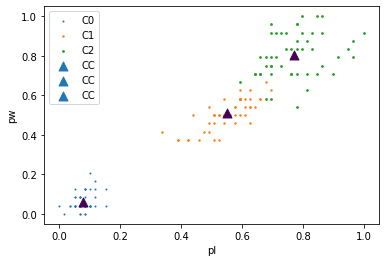

In [15]:
# plotting original cluters (along with clusters centers)
plotClusters(df,labels,get_cluster_centers(df,labels))

###**DBSCAN using of Sklearn Library**

In [16]:
#creating our DBSCAN model using sklearn
model=DBSCAN(eps=0.06, min_samples=3)
#fit the df in our model
model.fit(df)
# predicted labels by model
predicted_labels=pd.Series(model.labels_)

In [17]:
predicted_labels.unique()

array([ 0,  1, -1,  2])

In [18]:
#Printing the sklearn DB_SCAN Model specifications
print("sklearn DB_SCAN model Specifications :-")
print("inertia_ : ",getInertia(df,predicted_labels))
print("n_features = ",model.n_features_in_)
print("")

sklearn DB_SCAN model Specifications :-
inertia_ :  4.259187457075546
n_features =  2



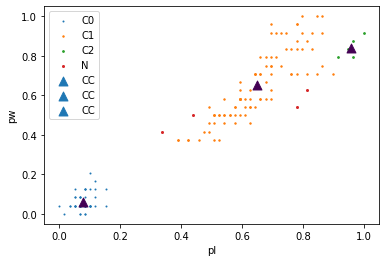

In [19]:
# plotting predicted cluters (along with clusters centers) using sklearn DBSCAN model
'''
Colors of clusters are diffrent because K-means is Unsupervised learning so,
it autimatically put cluster names as 0,1,2...
'''
plotClusters(df,predicted_labels,get_cluster_centers(df,predicted_labels))

###**DB_SCAN Using Our Algorithm**

In [20]:
# Now Using Our DB_SCAN Model
mymodel=DB_SCAN(eps=0.06,min_samples=3)
#fit the df in our model
mymodel.fit(df)
# predicted labels by model
my_predicted_labels=mymodel.labels_

In [21]:
#Printing my DB_SCAN Model specifications
print(mymodel.specs_())

{'inertia_': 4.259187457075546, 'cluster_cnt_': 3, 'cluster_centers_': array([[0.07830508, 0.06083333],
       [0.64872416, 0.65247253],
       [0.95932203, 0.84166667]]), 'n_features_in_': 150}


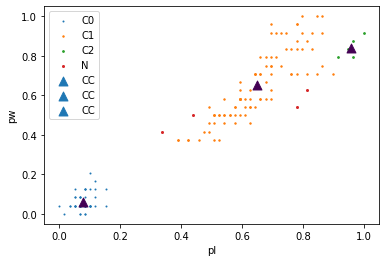

In [22]:
# plotting predicted cluters (along with clusters centers) using my DB_SCAN model
'''
Colors of clusters are diffrent because K_Means is Unsupervised learning so,
it autimatically put cluster names as 0,1,2...
'''
plotClusters(df,my_predicted_labels,mymodel.cluster_centers_)

###As we can see the DBSCAN is not suitable for iris dataset!!!


###**Running DBSCAN on suitable data for DBSCAN**

In [23]:
# Generating suitable dataset
n_samples=250
noisy_moons = datasets.make_circles(n_samples=n_samples, noise=.03,factor=0.5)
X = noisy_moons[0]
good_df=pd.DataFrame(data=X,columns=['x','y'])

In [24]:
good_df.head()

,x,y
0,0.448898,-0.113942
1,-0.837845,-0.555223
2,-0.432214,-0.198767
3,-1.030692,-0.167798
4,-0.403369,-0.240588


###**DBSCAN on good data using of Sklearn Library**

In [25]:
#creating our DBSCAN model using sklearn
good_model=DBSCAN(eps=0.3, min_samples=10)
#fit the good_df in our model
good_model.fit(good_df)
# predicted labels by model
good_predicted_labels=pd.Series(good_model.labels_)

In [26]:
good_predicted_labels.unique()

array([0, 1])

In [27]:
#Printing the sklearn DB_SCAN Model specifications
print("sklearn DB_SCAN good_model Specifications :-")
print("inertia_ : ",getInertia(good_df,good_predicted_labels))
print("n_features = ",good_model.n_features_in_)
print("")

sklearn DB_SCAN good_model Specifications :-
inertia_ :  156.44404536756298
n_features =  2



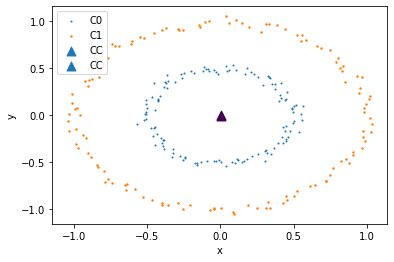

In [28]:
# plotting predicted cluters (along with clusters centers) using sklearn DBSCAN model
'''
Colors of clusters are diffrent because DBSCAN is Unsupervised learning so,
it autimatically put cluster names as 0,1,2...
'''
plotClusters(good_df,good_predicted_labels,get_cluster_centers(good_df,good_predicted_labels))

###**DBSCAN on good data using of my Algo**

In [29]:
#creating our DBSCAN model using my Algo
my_good_model=DB_SCAN(eps=0.3, min_samples=10)
#fit the good_df in our mymodel
my_good_model.fit(good_df)
# predicted labels by mymodel
my_good_predicted_labels=pd.Series(my_good_model.labels_)

In [30]:
my_good_predicted_labels.unique()

array([0., 1.])

In [31]:
#Printing  DB_SCAN my_good_model specifications
print(my_good_model.specs_())

{'inertia_': 156.44404536756298, 'cluster_cnt_': 2, 'cluster_centers_': array([[ 0.00331548, -0.00814426],
       [ 0.0015024 , -0.00164222]]), 'n_features_in_': 250}


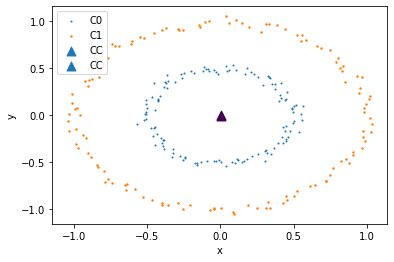

In [32]:
# plotting predicted cluters (along with clusters centers) using my DB_SCAN model
'''
Colors of clusters are diffrent because DBSCAN is Unsupervised learning so,
it autimatically put cluster names as 0,1,2...
'''
plotClusters(good_df,my_good_predicted_labels,my_good_model.cluster_centers_)

***Any Improvments or Suggestions are welcomed***

###**Thank You** 🙂







Created by : Abhijit Kumar (CSE student at NIT Durgapur)

Date : 15-11-2022

**©AbhijitKumar**